<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Unit4/Max_Bentley_Unit4ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
# import chemshift data + data manip (copied)

#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [ ]:
# chemshift, normal

with pm.Model(coords=aa_coords) as cs_hn_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_hn = pm.sample()

Output()

Output()

In [ ]:
# chemshift, student-t
with pm.Model(coords=aa_coords) as cs_hs_model:
  # hyperpriors. Notice how there's no dims argument.
  #this means that the hyperprior is shared across all amino acids
  μ_mu = pm.StudentT('μ_mu', nu=2, mu = 0, sigma = 10)
  μ_sd = pm.HalfStudentT('μ_sd', nu=2, sigma = 10)
  μ_nu = pm.Exponential('μ_nu', lam=1/30)

  # priors. There is a different prior for each amino acid,
  #but now the μ priors 'talk' to one another through μ_mu and μ_sd
  μ = pm.StudentT('μ',
                mu = μ_mu,
                sigma = μ_sd,
                nu = μ_nu,
                dims = "aa")

  σ = pm.HalfStudentT('σ',
                      sigma = 10,
                      nu = 30,
                      dims = "aa")

  nu = pm.Exponential('nu',
                       lam = 1/30,
                       dims = "aa")

  #likelihood; same as before
  y = pm.StudentT('y',
                nu = nu[aa_idx],
                mu = μ[aa_idx],
                sigma = σ[aa_idx],
                observed = cs_data.diff_TminusE)

  #cs for chemshift, h for heirarchical
  idata_cs_hs = pm.sample()

Output()

Output()

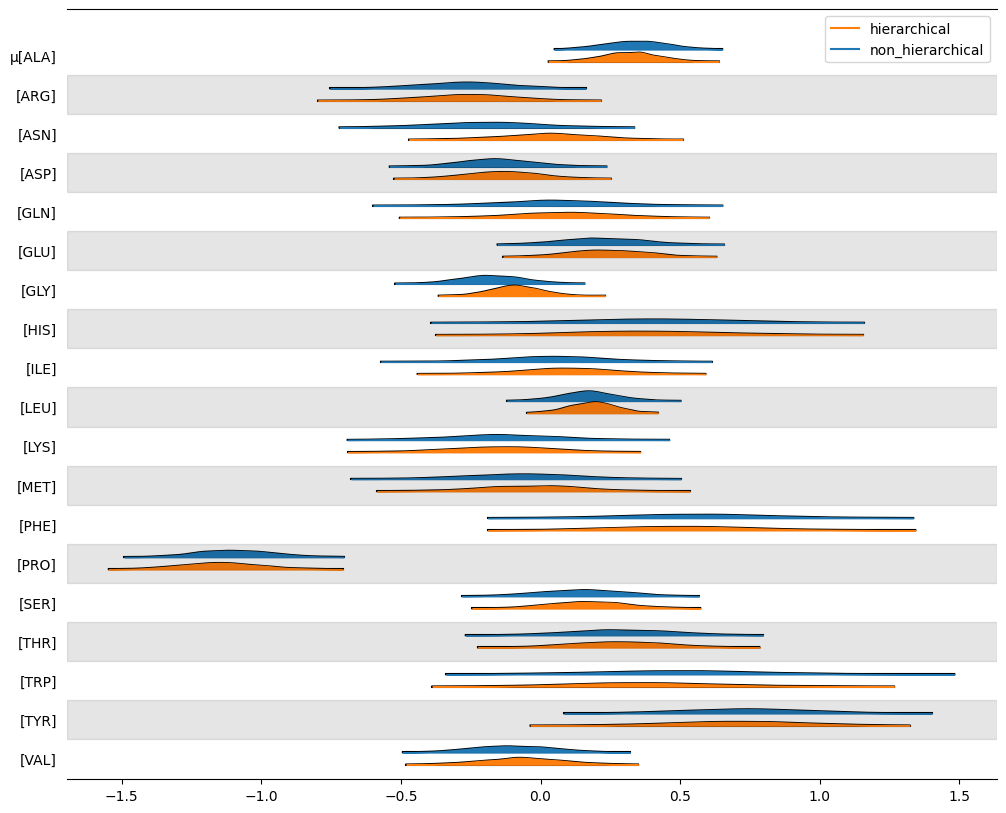

In [ ]:
# ridgeplot

axes = az.plot_forest([idata_cs_hn, idata_cs_hs], kind="ridgeplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)


**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

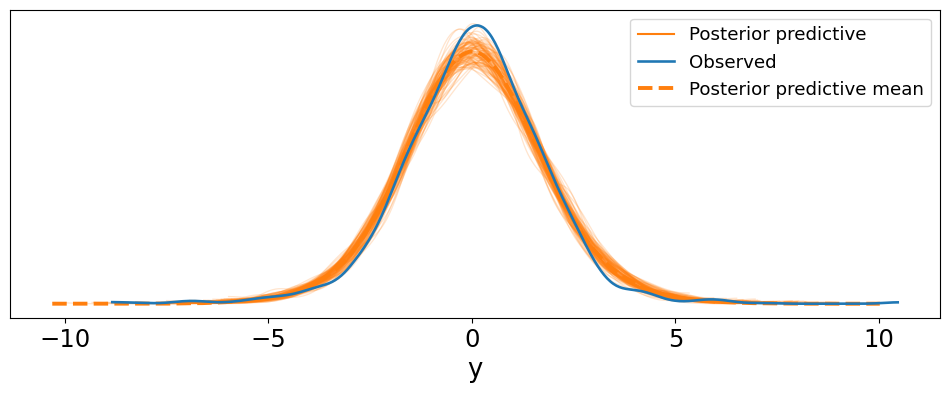

In [ ]:
# ppc (normal)

pm.sample_posterior_predictive(idata_cs_hn, model=cs_hn_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_hn, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

<Axes: xlabel='y'>

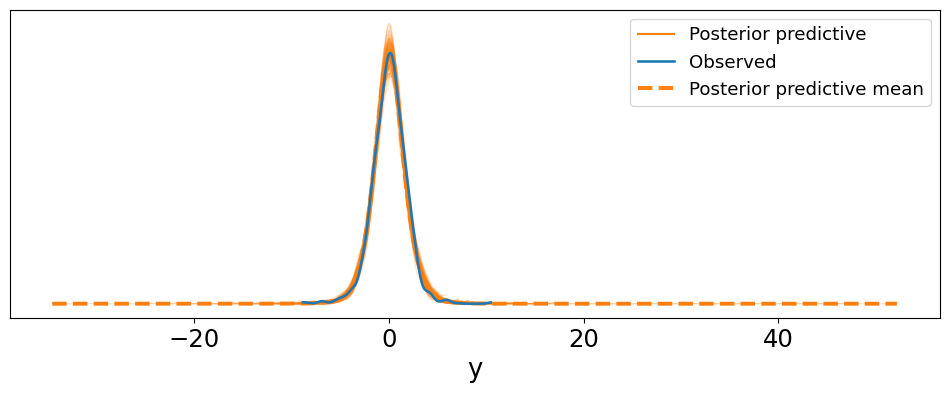

In [ ]:
# ppc (student-t)

pm.sample_posterior_predictive(idata_cs_hs, model=cs_hs_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_hs, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**The student-t looks like it represents the data better, mainly because the peak looks better fit. It's a pretty marginal difference, though, so either probably works for our application.**

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
# data import + cleanup (copied from notes)
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
# new non-hierarchical model
with pm.Model(coords = sccr_coords) as sccr_nh_model:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

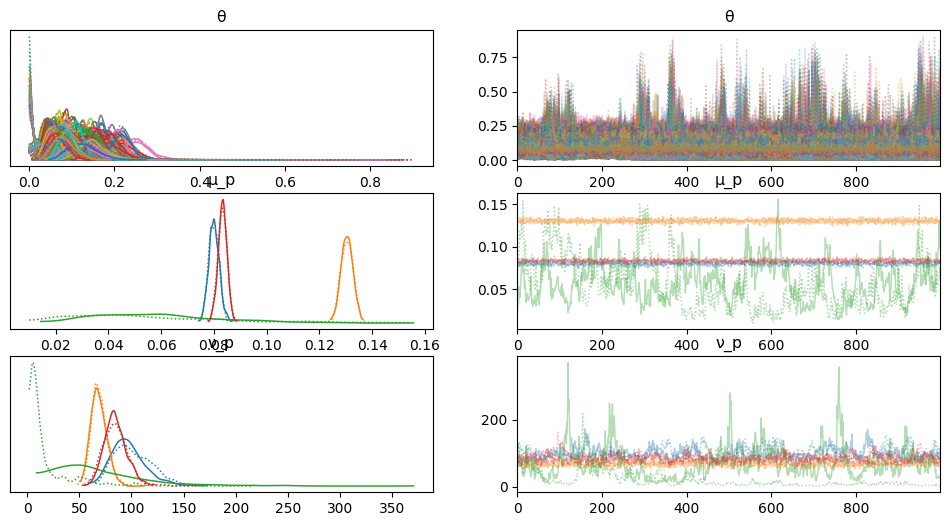

In [ ]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
#...which also takes 6 to 8 minutes to run
az.plot_trace(idata_sccr)

In [ ]:
# rhat
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 0.9991 0.9999 ... 0.9996 1.006 1.002
    μ_p      (pos) float64 32B 1.002 1.0 1.093 1.001
    ν_p      (pos) float64 32B 1.017 1.002 1.593 1.004

**The non-hierarchical model seems a lot more noisy than the hierarchical model, so the hierarchical model is better than the non-hierarchical model.**

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

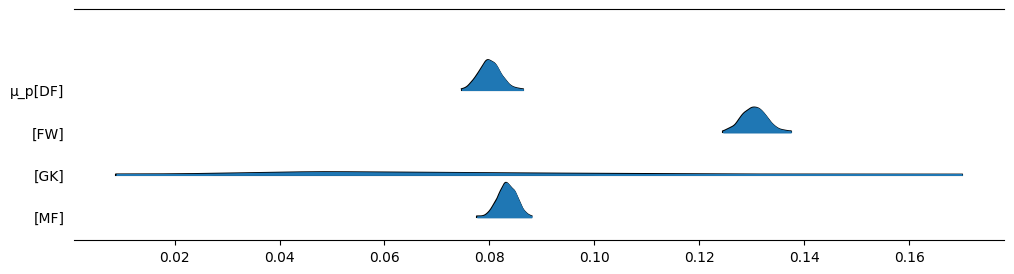

In [ ]:
# ridgeplot

az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**They look about the same.**

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
# dataset cleanup

# setup variables
idx = 0       # keeps track of the index through the dataset
rmIdx = 0     # accounts for deleted rows offsetting
rmList = []   # list of all row indexes with GKs

# creates a list of all rows that are goalkeepers
for i in sccr_data["position"].values:
  if i == "GK":
    rmList.append(idx)

  idx += 1

# remove offending rows
for i in rmList:
  sccr_data = sccr_data.drop(sccr_data.index[i-rmIdx])
  rmIdx += 1

sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
# more setup (this is mostly copy-pasted and slightly edited)

#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

# remove GKs from the pymc-read coords
sccr_coords["pos"] = sccr_coords["pos"].delete(2)

sccr_coords

{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}

In [ ]:
# change pos_idx to remove GKs
# i've dug myself into a "shitty code" loop but i'm too far in now

# change type from the immutable numpy array to the mutable python list
templist = list(pos_idx)

# subtract 1 from every position of "3", since it should be max 2 instead
for i in range(0, len(templist)):
  if templist[i] == 3:
    templist[i] -= 1

# convert back to numpy array
pos_idx = np.array(templist)

In [ ]:
# model copy-pasted from notes

with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #posterior
    idata_sccr2 = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

**The non-GKs model was much easier for pymc to process. The non-GKs model finished in around five minutes, while the GKs model took several minutes longer.**

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

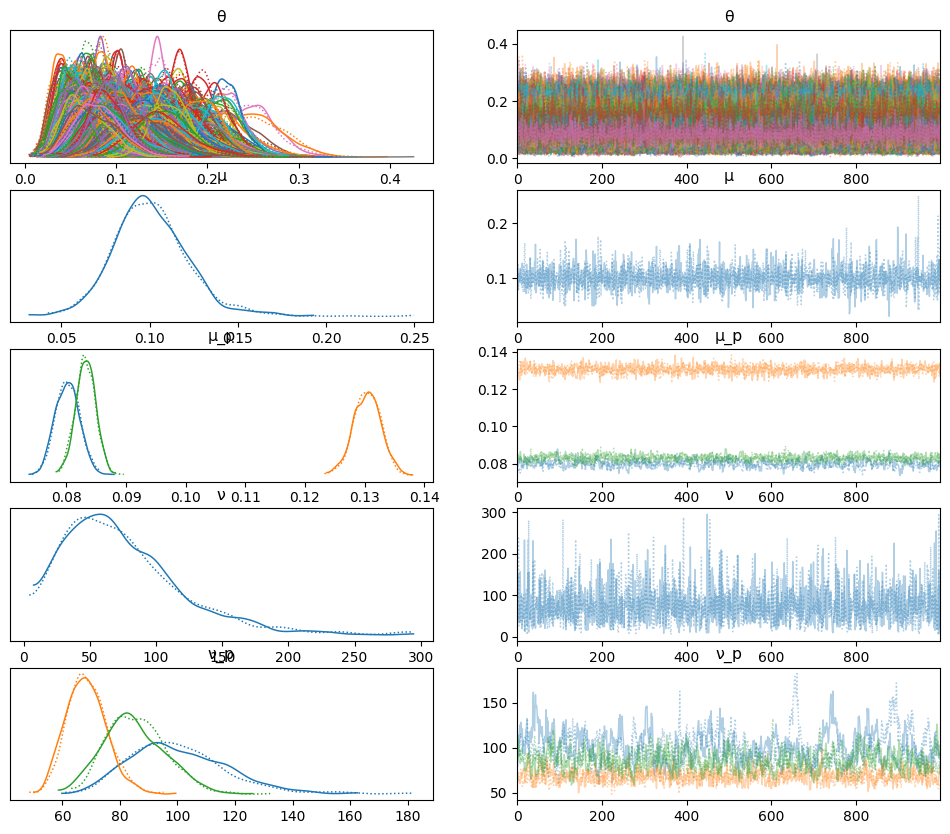

In [ ]:
az.plot_trace(idata_sccr2)

In [ ]:
#Using arviZ to find the rhat values
az.rhat(idata_sccr2)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.004 1.003 1.0 1.004 ... 1.001 1.003 1.001
    μ        float64 8B 0.9993
    μ_p      (pos) float64 24B 1.009 1.001 1.002
    ν        float64 8B 1.0
    ν_p      (pos) float64 24B 1.008 1.007 1.002

**By dropping the GKs from the dataset, our chains generally become slightly more noisy (as demonstrated by the Rhat values), so we're losing some precision, but it's a pretty small difference. On the other hand, we're gaining a lot of time back, as the model no longer has to run the model for GKs.**